In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor

from tensorflow.keras.models import load_model
from YAD2K.yad2k.models.keras_yolo import yolo_head
from YAD2K.yad2k.utils.draw_boxes import draw_boxes, get_colors_for_classes
from YAD2K.yad2k.models.keras_yolo import preprocess_true_boxes
from YAD2K.retrain_yolo import get_classes, get_anchors, create_model, process_data

%matplotlib inline

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    x = 10
    y = tf.constant(100)
    
    # YOUR CODE STARTS HERE

    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = box_class_probs*box_confidence
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    # YOUR CODE ENDS HERE
    
    return scores, boxes, classes

In [3]:
tf.random.set_seed(10)
box_confidence = tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([19, 19, 5, 4], mean=1, stddev=4, seed = 1)
box_class_probs = tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.5)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.shape))
print("boxes.shape = " + str(boxes.shape))
print("classes.shape = " + str(classes.shape))

assert type(scores) == EagerTensor, "Use tensorflow functions"
assert type(boxes) == EagerTensor, "Use tensorflow functions"
assert type(classes) == EagerTensor, "Use tensorflow functions"

assert scores.shape == (1789,), "Wrong shape in scores"
assert boxes.shape == (1789, 4), "Wrong shape in boxes"
assert classes.shape == (1789,), "Wrong shape in classes"

assert np.isclose(scores[2].numpy(), 9.270486), "Values are wrong on scores"
assert np.allclose(boxes[2].numpy(), [4.6399336, 3.2303846, 4.431282, -2.202031]), "Values are wrong on boxes"
assert classes[2].numpy() == 8, "Values are wrong on classes"

print("\033[92m All tests passed!")

scores[2] = 9.270486
boxes[2] = [ 4.6399336  3.2303846  4.431282  -2.202031 ]
classes[2] = 8
scores.shape = (1789,)
boxes.shape = (1789, 4)
classes.shape = (1789,)
 All tests passed!


In [4]:
# GRADED FUNCTION: iou

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """


    (box1_x1, box1_y1, box1_x2, box1_y2) = box1
    (box2_x1, box2_y1, box2_x2, box2_y2) = box2

    # YOUR CODE STARTS HERE
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ##(≈ 7 lines)
    xi1 = max(box1_x1,box2_x1)
    yi1 = max(box1_y1,box2_y1)
    xi2 = min(box1_x2,box2_x2)
    yi2 = min(box1_y2,box2_y2)
    inter_width = max(0,yi2 - yi1)
    inter_height = max(0,xi2 - xi1)
    inter_area = inter_width*inter_height

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ## (≈ 3 lines)
    box1_area = (box1_x2-box1_x1)*((box1_y2-box1_y1))
    box2_area = (box2_x2-box2_x1)*((box2_y2-box2_y1))
    union_area = box1_area + box2_area - inter_area
    
    # compute the IoU
    ## (≈ 1 line)
    iou = inter_area/union_area
    
    # YOUR CODE ENDS HERE
    
    return iou

In [5]:
## Test case 1: boxes intersect
box1 = (2, 1, 4, 3)
box2 = (1, 2, 3, 4)

print("iou for intersecting boxes = " + str(iou(box1, box2)))
assert iou(box1, box2) < 1, "The intersection area must be always smaller or equal than the union area."
assert np.isclose(iou(box1, box2), 0.14285714), "Wrong value. Check your implementation. Problem with intersecting boxes"

## Test case 2: boxes do not intersect
box1 = (1,2,3,4)
box2 = (5,6,7,8)
print("iou for non-intersecting boxes = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection must be 0"

## Test case 3: boxes intersect at vertices only
box1 = (1,1,2,2)
box2 = (2,2,3,3)
print("iou for boxes that only touch at vertices = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at vertices must be 0"

## Test case 4: boxes intersect at edge only
box1 = (1,1,3,3)
box2 = (2,3,3,4)
print("iou for boxes that only touch at edges = " + str(iou(box1,box2)))
assert iou(box1, box2) == 0, "Intersection at edges must be 0"

print("\033[92m All tests passed!")

iou for intersecting boxes = 0.14285714285714285
iou for non-intersecting boxes = 0.0
iou for boxes that only touch at vertices = 0.0
iou for boxes that only touch at edges = 0.0
 All tests passed!


In [6]:
# GRADED FUNCTION: yolo_non_max_suppression

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE

    
    return scores, boxes, classes

In [7]:
tf.random.set_seed(10)
scores = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
boxes = tf.random.normal([54, 4], mean=1, stddev=4, seed = 1)
classes = tf.random.normal([54,], mean=1, stddev=4, seed = 1)
scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes)

assert type(scores) == EagerTensor, "Use tensoflow functions"
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"

assert np.isclose(scores[2].numpy(), 8.147684), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [ 6.0797963, 3.743308, 1.3914018, -0.34089637]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 1.7079165), "Wrong value on classes"

print("\033[92m All tests passed!")

scores[2] = 8.147684
boxes[2] = [ 6.0797963   3.743308    1.3914018  -0.34089637]
classes[2] = 1.7079165
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


In [8]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])

In [9]:
## Citation: GPT-4
def scale_boxes(boxes, image_shape):
    """Scales the bounding boxes to the original image size.
    
    Arguments:
    boxes -- tensor of shape (None, 4), predicted box coordinates
    image_shape -- tuple of shape (2,) containing the height and width of the original image
    
    Returns:
    scaled_boxes -- tensor of shape (None, 4), scaled box coordinates
    """
    height = image_shape[0]
    width = image_shape[1]
    image_dims = tf.stack([height, width, height, width])
    image_dims = tf.cast(image_dims, dtype=tf.float32)
    scaled_boxes = boxes * image_dims
    return scaled_boxes


In [10]:
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)

    # Scale boxes back to original image shape (720, 1280 or whatever)
    boxes = scale_boxes(boxes, image_shape) # Network was trained to run on 608x608 images

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    return scores, boxes, classes

In [11]:
tf.random.set_seed(10)
yolo_outputs = (tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 2], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 1], mean=1, stddev=4, seed = 1),
                tf.random.normal([19, 19, 5, 80], mean=1, stddev=4, seed = 1))
scores, boxes, classes = yolo_eval(yolo_outputs)
print("scores[2] = " + str(scores[2].numpy()))
print("boxes[2] = " + str(boxes[2].numpy()))
print("classes[2] = " + str(classes[2].numpy()))
print("scores.shape = " + str(scores.numpy().shape))
print("boxes.shape = " + str(boxes.numpy().shape))
print("classes.shape = " + str(classes.numpy().shape))

assert type(scores) == EagerTensor, "Use tensoflow functions"
assert type(boxes) == EagerTensor, "Use tensoflow functions"
assert type(classes) == EagerTensor, "Use tensoflow functions"

assert scores.shape == (10,), "Wrong shape"
assert boxes.shape == (10, 4), "Wrong shape"
assert classes.shape == (10,), "Wrong shape"
    
assert np.isclose(scores[2].numpy(), 171.60194), "Wrong value on scores"
assert np.allclose(boxes[2].numpy(), [-1240.3483, -3212.5881, -645.78, 2024.3052]), "Wrong value on boxes"
assert np.isclose(classes[2].numpy(), 16), "Wrong value on classes"
    
print("\033[92m All tests passed!")

scores[2] = 171.60194
boxes[2] = [-1240.3483 -3212.5881  -645.78    2024.3052]
classes[2] = 16
scores.shape = (10,)
boxes.shape = (10, 4)
classes.shape = (10,)
 All tests passed!


In [12]:
class_names = get_classes("YAD2K/model_data/coco_classes.txt")
anchors = get_anchors("YAD2K/model_data/yolo_anchors.txt")
model_image_size = (608, 608) # Same as yolo_model input layer size

In [13]:
yolo_model = load_model("YAD2K/model_data/yolo.h5", compile=False)
yolo_model.summary()

/Users/klinalb/anaconda3/envs/yad2k/lib/python3.8/site-packages/keras/src/layers/core/lambda_layer.py:327: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(
/Users/klinalb/anaconda3/envs/yad2k/lib/python3.8/site-packages/keras/src/layers/core/lambda_layer.py:331: UserWarning: yad2k.models.keras_yolo is not loaded, but a Lambda layer uses it. It may cause errors.
  output_shape = cls._parse_function_from_config(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 608, 608, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 608, 608, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 608, 608, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 608, 608, 32)         0         ['batch_normalization[0][0

In [14]:
def preprocess_image(img_path, model_image_size):
    """
    Preprocesses the image for YOLO model.
    
    Parameters:
    img_path (str): Path to the image file.
    model_image_size (tuple): The expected input size for the model, e.g., (608, 608).
    
    Returns:
    image: A PIL instance of the original image.
    image_data: A numpy array of the resized and normalized image.
    """
    # Load the image with PIL
    image = Image.open(img_path)
    
    # Resize the image with the specified model input size
    resized_image = image.resize(model_image_size, Image.BICUBIC)
    
    # Convert the image to a numpy array
    image_data = np.array(resized_image, dtype="float32")
    
    # Normalize the image data
    image_data /= 255.
    
    # Add a batch dimension because the model expects it
    image_data = np.expand_dims(image_data, axis=0)
    
    return image, image_data


In [33]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("YAD2K/images/" + image_file, model_image_size = (608, 608))

    # convert PIL image to image: An `array` of shape (width, height, 3) with values in [0, 1].
    # image = np.array(image)
    
    yolo_model_outputs = yolo_model(image_data) # It's output is of shape (m, 19, 19, 5, 85) 
    # But yolo_eval takes input a tensor contains 4 tensors: box_xy,box_wh, box_confidence & box_class_probs
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    # print(image.size[1])
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    image = image.convert("RGB")
    np_image = np.array(image)
    # print("Image array shape:", np_image.shape)
    # print("Pixel value range before scaling:", np.min(np_image), np.max(np_image))

    image = draw_boxes(np_image, out_boxes, out_classes, class_names, out_scores)
    plt.imshow(image)
    plt.show()

    image.save(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ))

    return out_scores, out_boxes, out_classes


Found 3 boxes for images/dog.jpg
First pixel RGB value:  (57, 58, 50)
First pixel RGB value:  (57, 58, 50)
First pixel RGB value:  (57, 58, 50)
bicycle (80, 113) (555, 468)
truck (462, 82) (694, 168)
dog (137, 214) (323, 540)
First pixel RGB value:  (57, 58, 50)


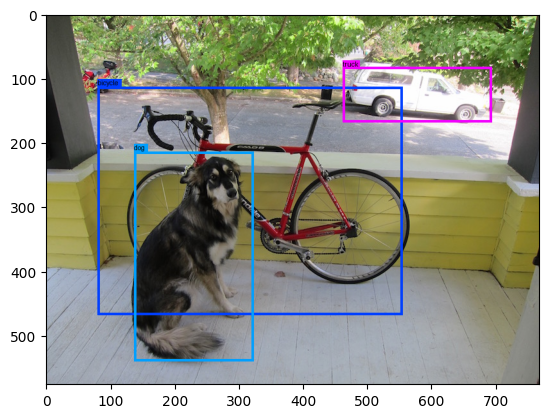

Found 0 boxes for images/scream.jpg
First pixel RGB value:  (197, 177, 126)
First pixel RGB value:  (197, 177, 126)
First pixel RGB value:  (197, 177, 126)
First pixel RGB value:  (197, 177, 126)


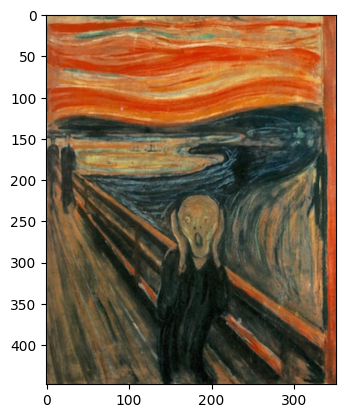

Found 1 boxes for images/eagle.jpg
First pixel RGB value:  (74, 80, 106)
First pixel RGB value:  (74, 80, 106)
First pixel RGB value:  (74, 80, 106)
bird (128, 47) (643, 468)
First pixel RGB value:  (74, 80, 106)


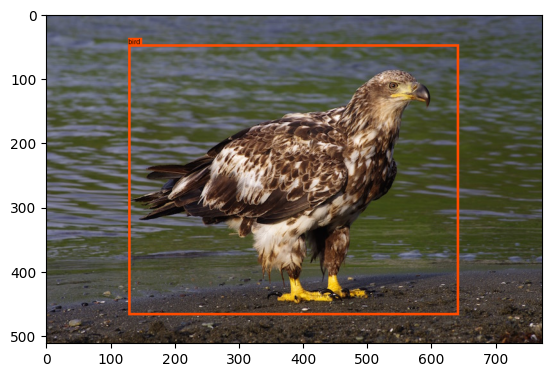

Found 3 boxes for images/person.jpg
First pixel RGB value:  (191, 203, 241)
First pixel RGB value:  (191, 203, 241)
First pixel RGB value:  (191, 203, 241)
horse (399, 128) (605, 352)
person (190, 97) (271, 379)
dog (70, 258) (209, 356)
First pixel RGB value:  (191, 203, 241)


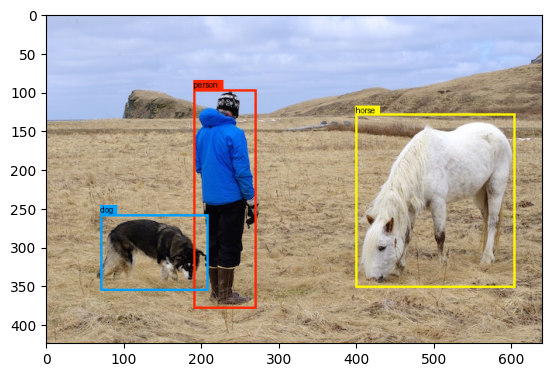

Found 3 boxes for images/car.jpg
First pixel RGB value:  (100, 120, 145)
First pixel RGB value:  (100, 120, 145)
First pixel RGB value:  (100, 120, 145)
car (361, 294) (747, 650)
car (942, 327) (1280, 693)
car (770, 297) (938, 403)
First pixel RGB value:  (100, 120, 145)


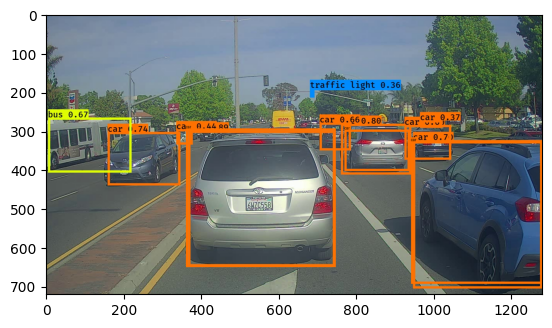

Found 2 boxes for images/giraffe.jpg
First pixel RGB value:  (0, 27, 5)
First pixel RGB value:  (0, 27, 5)
First pixel RGB value:  (0, 27, 5)
giraffe (166, 0) (439, 448)
zebra (241, 208) (422, 442)
First pixel RGB value:  (0, 27, 5)


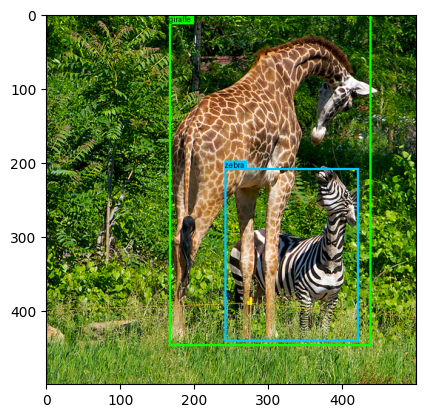

Found 4 boxes for images/horses.jpg
First pixel RGB value:  (139, 148, 177)
First pixel RGB value:  (139, 148, 177)
First pixel RGB value:  (139, 148, 177)
horse (7, 193) (305, 411)
horse (435, 210) (603, 350)
horse (253, 196) (436, 371)
horse (0, 188) (169, 378)
First pixel RGB value:  (139, 148, 177)


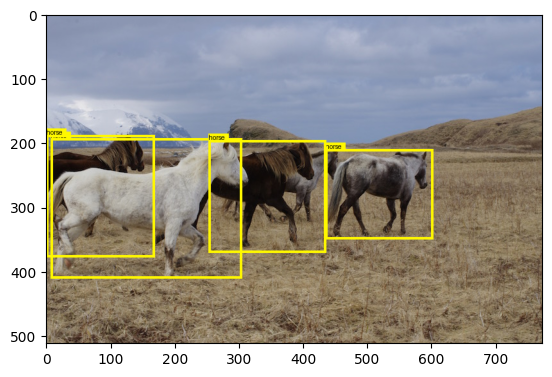

In [34]:
IMAGES_DIR = "YAD2K/images/"

for image_file in os.listdir(IMAGES_DIR):
    if image_file.endswith(".jpg") or image_file.endswith(".png"):
        out_scores, out_boxes, out_classes = predict(image_file)